# Global Sequence MIP Formulation (M1* formulation in paper)

## Model Declaration and Data Input (Example 4)

In [1]:
from pyomo import environ as pe
from math import ceil
model = pe.ConcreteModel(name='Global Sequence MIP Formulation')

In [2]:
data_object = None
try:
    data_object  = open('Example4.dat', 'w')
    data_object.write('''
    
table I={I} q_min(I)    q_max(I)     r(I)     d(I)     pi(I):
      I     q_min       q_max.       r        d        pi   :=
      A     50          70           10       60       11
      B     50          50           5        60       6
      C     50          80           0        60       11
      D     50          50           5        60       6
      E     50          60           10       60       9
      F     50          100          0        60       10
      G     50          50           20       60       9
      H     50          80           0        60       7;

set K := K1 K2;

table J={J}  Jk={J,K}  b_min(J)  b_max(J):
      J      K         b_min     b_max   :=
      J1     K1        10        25
      J2     K1        10        25
      J3     K1        15        30
      J4     K2        10        25
      J5     K2        15        30
      J6     K2        10        25;

set JF := (A,J1);
set FP := (J1,J6) (J2,J5);

param tau_F :     J1              J2              J3                J4               J5                J6 :=
            A     3.244444444444  2.888888888889  3.13333333333333  2.3111111111111  2.23333333333333  2.2222222222222
            B     3.244444444444  2.888888888889  3.13333333333333  2.3111111111111  2.23333333333333  2.2222222222222
            C     3.244444444444  2.888888888889  3.13333333333333  2.3111111111111  2.23333333333333  2.2222222222222
            D     2.888888888889  3.333333333333  2.83333333333333  2.0              2.33333333333333  2.1333333333333
            E     2.888888888889  3.333333333333  2.83333333333333  2.0              2.33333333333333  2.1333333333333
            F     2.888888888889  3.333333333333  2.83333333333333  2.0              2.33333333333333  2.1333333333333
            G     3.022222222222  3.333333333333  3.0               2.1333333333333  2.16666666666667  2.2222222222222
            H     3.022222222222  3.333333333333  3.0               2.1333333333333  2.16666666666667  2.2222222222222;

param tau_P :     J1     J2     J3     J4     J5     J6 :=
            A     0.162  0.144  0.209  0.116  0.148  0.111
            B     0.162  0.144  0.209  0.116  0.148  0.111
            C     0.162  0.144  0.209  0.116  0.148  0.111
            D     0.144  0.166  0.189  0.100  0.156  0.106
            E     0.144  0.166  0.189  0.100  0.156  0.106
            F     0.144  0.166  0.189  0.100  0.156  0.106
            G     0.151  0.166  0.2    0.106  0.144  0.111
            H     0.151  0.166  0.2    0.106  0.144  0.111;

param c_F :       J1  J2  J3  J4  J5  J6 :=
            A     .   85  90  100 100 110
            B     50  52  41  91  91  91
            C     100 110 90  50  50  55
            D     20  10  10  61  61  61
            E     80  80  90  110 120 130
            F     70  70  70  40  40  30
            G     100 100 100 90  90  100
            H     10  30  40  45  45  45;

table H := 60;

''')
finally:
    data_object.close()
    
data = pe.DataPortal()
data.load(filename="Example4.dat", model=model)

## Set Declaration

In [3]:
model.I = pe.Set(initialize=data['I'],ordered=True)
model.J = pe.Set(initialize=data['J'],ordered=True)
model.K = pe.Set(initialize=data['K'],ordered=True)
model.Jk = pe.Set(within=model.J*model.K,initialize=data['Jk'])
model.JF = pe.Set(within=model.I*model.J,initialize=data['JF'])
model.FP = pe.Set(within=model.J*model.J,initialize=data['FP'])

## Special Set: $JA_{ik}$

In [4]:
def JAik_rule(model):
    tmp = []
    for j in model.J:
        for i in model.I:
            for k in model.K:
                if ((j,k) in model.Jk) and ((i,j) not in model.JF):
                    tmp.append((j,i,k))
    return tmp
model.JAik = pe.Set(within=model.J*model.I*model.K,initialize=JAik_rule)

## Parameters Declaration

In [5]:
model.H = pe.Param(initialize=data['H'])
model.q_min = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['q_min'])
model.q_max = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['q_max'])
model.r = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['r'],default=0)
model.d = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['d'],default=model.H)
model.b_min = pe.Param(model.J,within=pe.NonNegativeReals,initialize=data['b_min'])
model.b_max = pe.Param(model.J,within=pe.NonNegativeReals,initialize=data['b_max'])
model.tau_F = pe.Param(model.I,model.J,within=pe.NonNegativeReals,initialize=data['tau_F'])
model.tau_P = pe.Param(model.I,model.J,within=pe.NonNegativeReals,initialize=data['tau_P'])

## Special Set: $L_i$

* (1)
* (2)

In [6]:
# First, we need to compute for each i, what is the minimum batch size across all stages
def bi_min_rule(model,i):
    return max(min(model.b_min[j] for j in model.J if (j,i,k) in model.JAik) for k in model.K)
model.bi_min = pe.Param(model.I,initialize=bi_min_rule)

def bi_max_rule(model,i):
    return min(max(model.b_max[j] for j in model.J if (j,i,k) in model.JAik) for k in model.K)
model.bi_max = pe.Param(model.I,initialize=bi_max_rule)

# Second, we can use demand data, compute upper and lower bound for the number of batches
def li_max_rule(model,i):
    return ceil(model.q_max[i]/model.bi_min[i])
model.li_max = pe.Param(model.I,initialize=li_max_rule)

def li_min_rule(model,i):
    return ceil(model.q_min[i]/model.bi_max[i])
model.li_min = pe.Param(model.I,initialize=li_min_rule)

# Third, construct the L(i) list
def Li_rule(model):
    tmp = []
    for i in model.I:
        for l in range(1,model.li_max[i]+1):
            tmp.append((i,l))
    return tmp
model.Li = pe.Set(dimen=2,initialize=Li_rule,ordered=True)

## Batching and Assignment Variables Declaration

In [7]:
model.B = pe.Var(model.Li,within=pe.NonNegativeReals)
model.B_ = pe.Var(model.Li,model.J,within=pe.NonNegativeReals)
model.Z = pe.Var(model.Li,within=pe.Binary)
model.X = pe.Var(model.Li,model.J,within=pe.Binary)

In [8]:
for i,l in model.B:
    model.B[i,l].setub(model.bi_max[i])

for i,l,j in model.B_:
    model.B_[i,l,j].setub(model.bi_max[i])

## Batching and Assignment Constraints

* (3) add (3a)

In [9]:
def demand_rule(model,i):
    return sum(model.B[i_,l] for i_,l in model.Li if i_ == i) >= model.q_min[i]
model.demand_con = pe.Constraint(model.I,rule=demand_rule)

def demand_rule2(model,i):
    return sum(model.B[i_,l] for i_,l in model.Li if i_ == i) <= model.q_max[i]
model.demand_con2 = pe.Constraint(model.I,rule=demand_rule2)

* (4) According to paper, becomes obsolete with constraint 5-7

In [10]:
def batch_select_rule1(model,i,l):
    return model.B[i,l] <= model.bi_max[i]*model.Z[i,l]
model.batch_select_con1 = pe.Constraint(model.Li,rule=batch_select_rule1)

def batch_select_rule2(model,i,l):
    return model.bi_min[i]*model.Z[i,l] <= model.B[i,l]
model.batch_select_con2 = pe.Constraint(model.Li,rule=batch_select_rule2)

* (5)

In [11]:
def unit_select_rule(model,i,l,k):
    return model.Z[i,l] == sum(model.X[i,l,j] for j in model.J if (j,i,k) in model.JAik)
model.unit_select_con = pe.Constraint(model.Li,model.K,rule=unit_select_rule)

* (6)

In [12]:
def unit_size_rule(model,i,l,k):
    return model.B[i,l] == sum(model.B_[i,l,j] for j in model.J if (j,i,k) in model.JAik)
model.unit_size_con = pe.Constraint(model.Li,model.K,rule=unit_size_rule)

* (7)

In [13]:
def unit_bound_rule1(model,i,l,j):
    return model.B_[i,l,j] <= model.b_max[j]*model.X[i,l,j]
model.unit_bound_con1 = pe.Constraint(model.Li,model.J,rule=unit_bound_rule1)

def unit_bound_rule2(model,i,l,j):
    return model.b_min[j]*model.X[i,l,j] <= model.B_[i,l,j]
model.unit_bound_con2 = pe.Constraint(model.Li,model.J,rule=unit_bound_rule2)

* (8)

In [14]:
def batch_order_rule(model,i,l):
    if l == model.li_max[i]: return pe.Constraint.Skip
    return model.Z[i,l+1] <= model.Z[i,l]
model.batch_order_con = pe.Constraint(model.Li,rule=batch_order_rule)

## Special Set: $IL$

In [15]:
def IL_rule(model):
    tmp = []
    for i,l in model.Li:
        for i_,l_ in model.Li:
            if (i != i_) or (i == i_ and l != l_ ):
                tmp.append((i,l,i_,l_))
    return tmp
model.IL = pe.Set(dimen=4,initialize=IL_rule,ordered=True)

## Sequencing and Timing Variables Declaration

In [16]:
model.Y = pe.Var(model.IL,model.K,within=pe.Binary)
model.T = pe.Var(model.Li,model.K,within=pe.NonNegativeReals)
model.LT = pe.Var(model.Li,within=pe.NonNegativeReals)

for i,l,j in model.T:
    model.T[i,l,j].setub(model.d[i])

## Sequencing and Timing Constraints

* (9)

In [17]:
def same_unit_rule(model,i,l,i_,l_,k,j):
    if (model.I.ord(i) <= model.I.ord(i_)) and ((j,i,k) in model.JAik) and ((j,i_,k) in model.JAik):
        return model.X[i,l,j] + model.X[i_,l_,j] - 1 <= model.Y[i,l,i_,l_,k] + model.Y[i_,l_,i,l,k]
    else:
        return pe.Constraint.Skip
model.same_unit_con = pe.Constraint(model.IL,model.K,model.J,rule=same_unit_rule)

* (10)

In [18]:
def finish_time_rule(model,i,l,i_,l_,k):
    return model.T[i_,l_,k] >= model.T[i,l,k] - model.H*(1-model.Y[i,l,i_,l_,k]) + sum( (model.tau_F[i_,j] \
            *model.X[i_,l_,j] + model.tau_P[i_,j]*model.B_[i_,l_,j]) for j in model.J if (j,i_,k) in model.JAik)
model.finish_time_con = pe.Constraint(model.IL,model.K,rule=finish_time_rule)

* (11)

In [19]:
def between_stages_rule(model,i,l,k):
    if model.K.ord(k) == len(model.K): return pe.Constraint.Skip
    return model.T[i,l,model.K.next(k)] >= model.T[i,l,k] + sum((model.tau_F[i,j]*model.X[i,l,j] \
             + model.tau_P[i,j]*model.B_[i,l,j]) for j in model.J if (j,i,model.K.next(k)) in model.JAik)
model.between_stages_con = pe.Constraint(model.Li,model.K,rule=between_stages_rule)

## Additional Constraints

* (12) (13)

In [20]:
def start_rule(model,i,l,k):
    return model.T[i,l,k] >= model.r[i]*model.Z[i,l] + sum( (model.tau_F[i,j]*model.X[i,l,j] \
             + model.tau_P[i,j]*model.B_[i,l,j]) for k_ in model.K if model.K.ord(k_) <= model.K.ord(k) \
                                                           for j in model.J if (j,i,k_) in model.JAik )
model.start_con = pe.Constraint(model.Li,model.K,rule=start_rule)

def end_rule(model,i,l,k):
    return model.T[i,l,k] <= model.d[i]*model.Z[i,l] - sum( (model.tau_F[i,j]*model.X[i,l,j] \
             + model.tau_P[i,j]*model.B_[i,l,j]) for k_ in model.K if model.K.ord(k_) > model.K.ord(k) \
                                                           for j in model.J if (j,i,k_) in model.JAik )
model.end_con = pe.Constraint(model.Li,model.K,rule=end_rule)

* (14) (15)

In [21]:
def forbidden_path_rule(model,i,l,j,j_):
    if (j,j_) in model.FP: return model.X[i,l,j] + model.X[i,l,j_] <= model.Z[i,l]
    return pe.Constraint.Skip
model.forbidden_path_con = pe.Constraint(model.Li,model.J,model.J,rule=forbidden_path_rule)

def forbidden_assignment_rule(model,i,l,j):
    if (i,j) in model.JF: return model.X[i,l,j] == 0
    return pe.Constraint.Skip
model.forbidden_assignment_con = pe.Constraint(model.Li,model.J,rule=forbidden_assignment_rule)

* (16) (17)

In [22]:
def batch_size_sym_rule(model,i,l):
    if l == model.li_max[i]: return pe.Constraint.Skip
    return model.B[i,l+1] <= model.B[i,l]
model.batch_size_sym_con = pe.Constraint(model.Li,rule=batch_size_sym_rule)

def Z_force_rule(model,i,l):
    if l <= model.li_min[i]: return model.Z[i,l] == 1
    return pe.Constraint.Skip
model.Z_force_con = pe.Constraint(model.Li)

* (18) Not necessary here, all variables are defined without redundency
* (19) Already covered in variable declaration

- Fix lateness fixed to 0

In [23]:
for x in model.LT:
    model.LT[x].fix(0)

## Tightening Inequalities - Fixing of Sequencing Binaries

* (A1)
* (A2)
* (A3)
* (A4)

In [24]:
def tau_min_rule(model,i,j):
    if (i,j) in model.JF: return None
    return model.tau_F[i,j] + model.tau_P[i,j]*model.bi_min[i]
model.tau_min = pe.Param(model.I,model.J,initialize=tau_min_rule)

def est_rule(model,i,k):
    return model.r[i] + sum( min(model.tau_min[i,j] for j in model.J if (j,i,k_) in model.JAik) \
                            for k_ in model.K if model.K.ord(k_) < model.K.ord(k))
model.est = pe.Param(model.I,model.K,initialize=est_rule)

def eft_rule(model,i,k):
    return model.est[i,k] + min(model.tau_min[i,j] for j in model.J if (j,i,k) in model.JAik)
model.eft = pe.Param(model.I,model.K,initialize=eft_rule)

def lst_rule(model,i,k):
    return model.d[i] - sum( min(model.tau_min[i,j] for j in model.J if (j,i,k_) in model.JAik) \
                            for k_ in model.K if model.K.ord(k_) >= model.K.ord(k))
model.lst = pe.Param(model.I,model.K,initialize=lst_rule)

def lft_rule(model,i,k):
    return model.lst[i,k] + min(model.tau_min[i,j] for j in model.J if (j,i,k) in model.JAik)
model.lft = pe.Param(model.I,model.K,initialize=lft_rule)

* (26)

In [25]:
def mission_impossible_rule1(model,i,l,i_,l_,k):
    if model.eft[i,k] > model.lst[i_,k]: return model.Y[i,l,i_,l_,k] == 0
    return pe.Constraint.Skip
model.mission_impossible_con1 = pe.Constraint(model.IL,model.K,rule=mission_impossible_rule1)

* (A5)
* (A6)

In [26]:
def ubiij_rule(model,i,i_,j):
    if (i,j) in model.JF or (i_,j) in model.JF: return None
    for m in model.Jk:
        if m[0] == j: Kj = m[1]
    tmp1 = model.d[i] - model.tau_min[i,j] - sum( min(model.tau_min[i,j_] for j_ in model.J if (j_,i,k_) in model.JAik) \
                            for k_ in model.K if model.K.ord(k_) > model.K.ord(Kj))
    tmp2 = model.d[i_] - model.tau_min[i_,j] - model.tau_min[i,j] - sum( min(model.tau_min[i_,j_] \
                 for j_ in model.J if (j_,i_,k_) in model.JAik) for k_ in model.K if model.K.ord(k_) > model.K.ord(Kj))
    return min( tmp1,tmp2 )
model.ubiij = pe.Param(model.I,model.I,model.J,rule=ubiij_rule)

## Special Set $P_{i'k}$

In [27]:
def Pik_rule(model):
    tmp = []
    for i in model.I:
        for i_ in model.I:
            for k in model.K:
                if model.est[i,k] <= max( model.ubiij[i,i_,j] for j in model.J \
                                         if ((j,i,k) in model.JAik) and ((j,i_,k) in model.JAik)):
                    tmp.append((i,i_,k))
    return tmp
model.Pi_k = pe.Set(within=model.I*model.I*model.K,initialize=Pik_rule)     

* (27)

In [28]:
def mission_impossible_rule2(model,i,l,i_,l_,k):
    if (i,i_,k) not in model.Pi_k: return model.Y[i,l,i_,l_,k] == 0
    return pe.Constraint.Skip
model.mission_impossible_con2 = pe.Constraint(model.IL,model.K,rule=mission_impossible_rule2)

## Tightening Inequalities - Time Window

* (B1)

In [29]:
N = {}; lbw = {}; ubw = {}; tail = {}; ICjn = {}
ICjn
for j,k in model.Jk:
    IC_ = {i for i in model.I if (i,j) not in model.JF}
    n = 0
    while IC_ : 
        ICjn[j,n] = IC_
        while ICjn[j,n] and max(model.lft[i,k] for i in ICjn[j,n]) == max(model.lft[i,k] for i in IC_) :
            lbw[j,n] = min(model.est[i,k] for i in ICjn[j,n])
            ubw[j,n] = max(model.lft[i,k] for i in ICjn[j,n])
            tail[j,n] = min( sum( min( model.tau_min[i,j_] for j_ in model.J if (j_,i,k_) in model.JAik) \
                        for k_ in model.K if model.K.ord(k_) > model.K.ord(k)) for i in ICjn[j,n])
            ICjn[j,n+1] = ICjn[j,n] - {i for i in model.I if model.est[i,k] == lbw[j,n]}
            n = n+1
        IC_ = IC_ - {i for i in model.I if model.lft[i,k] == ubw[j,n-1]}
    N[j] = n
    ICjn.pop((j,n))

* (28)

In [30]:
#Using constraintlist instead, because of the way ICjn[j,n] is constructed
model.mission_impossible_con3 = pe.ConstraintList()
for j in N.keys():
    for n in range(N[j]):
        expr = sum(model.tau_F[i,j]*model.X[i,l,j] + model.tau_P[i,j]*model.B_[i,l,j] \
                   for i,l in model.Li if i in ICjn[j,n]) <= ubw[j,n] - lbw[j,n]
        model.mission_impossible_con3.add(expr)

## Objective Function

## Cost Parameter

In [31]:
model.c_F = pe.Param(model.I,model.J,within=pe.NonNegativeReals,initialize=data['c_F'])
model.pi = pe.Param(model.I,within=pe.NonNegativeReals,initialize=data['pi'])

* (23) (24) Minimize Earliness

In [32]:
model.obj = pe.Objective(expr= sum(model.pi[i]*model.B[i,l] for i in model.I for i_,l in model.Li if i_ == i) - \
                                sum(model.c_F[i,j]*model.X[i,l,j] for i, l in model.Li for j in model.J if (i,j) not in model.JF),sense=pe.maximize)

## Solve

In [33]:
opt = pe.SolverFactory('gurobi')
opt.solve(model,options={'mipgap':0},tee=True);

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Parameter mipgap unchanged
   Value: 0.0  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 16450 rows, 6589 columns and 94654 nonzeros
Variable types: 487 continuous, 6102 integer (6102 binary)
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [6e+00, 1e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+02]
Presolve removed 2916 rows and 163 columns
Presolve time: 0.33s
Presolved: 13534 rows, 6426 columns, 76856 nonzeros
Variable types: 394 continuous, 6032 integer (6032 binary)

Root relaxation: objective 2.084098e+03, 2065 iterations, 0.27 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2084.09771    0   23          - 2084.09771      -     -    1s
H    0     0    

## Result Interpretation

In [34]:
def model_pp(model):
    print('-'*90)
    print('Objective = {:.2f}'.format(model.obj()))
    for k in model.K:
        print('-'*90)
        print('Stage:',k)
        print('Units\tProd\tBatch\t\tProduction\tStart Time\tFinish Time')
        for i,l,j in model.X:
            if (j,k) in model.Jk and model.X[i,l,j] != 0:
                print(j,'\t',i,'\t',l,'\t\t{:.1f}\t\t{:.1f}\t\t{:.1f}'.format(model.B_[i,l,j].value,\
                model.T[i,l,k].value - (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value),model.T[i,l,k].value))

In [35]:
from matplotlib import pyplot as plt
def plot_gantt(model):
    fig = plt.figure(figsize=(20,9))
    ax = fig.add_subplot(111)
    for k in model.K:
        for i,l,j in model.X:
            if (j,k) in model.Jk and model.X[i,l,j] != 0:
                rect = ax.barh(model.J.ord(j), (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value), 0.5, left=model.T[i,l,k].value - (model.tau_F[i,j]+model.tau_P[i,j]*model.B_[i,l,j].value), align='center', color='None', edgecolor='Black',linewidth = 3)
                xloc = rect[0].get_x() + rect[-1].get_width()/2.0; yloc = rect[-1].get_y() + rect[-1].get_height()/2.0
                ax.text(xloc, yloc, '{},{},{:.0f}'.format(i,l,model.B_[i,l,j].value), horizontalalignment='center',verticalalignment='center', color='Black',clip_on=True,fontsize=14)
    ax.invert_yaxis()
    ax.set_yticklabels([1]+[j for j in model.J],fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.ylabel('Unit',fontsize=18)
    plt.xlabel('Time (h)',fontsize=18)
    plt.show()

------------------------------------------------------------------------------------------
Objective = 2056.00
------------------------------------------------------------------------------------------
Stage: K1
Units	Prod	Batch		Production	Start Time	Finish Time
J3 	 A 	 1 		30.0		27.6		37.0
J3 	 A 	 2 		30.0		37.0		46.4
J1 	 B 	 1 		25.0		14.1		21.4
J1 	 B 	 2 		25.0		21.6		28.9
J3 	 C 	 1 		30.0		-0.0		9.4
J1 	 C 	 2 		25.0		-0.0		7.3
J3 	 C 	 3 		25.0		46.4		54.8
J2 	 D 	 1 		25.0		22.4		29.9
J2 	 D 	 2 		25.0		37.4		44.9
J3 	 E 	 1 		30.0		10.0		18.5
J3 	 E 	 2 		30.0		18.5		27.0
J2 	 F 	 1 		25.0		-0.0		7.5
J2 	 F 	 2 		25.0		15.0		22.4
J2 	 F 	 3 		25.0		7.5		15.0
J2 	 F 	 4 		25.0		44.9		52.4
J1 	 G 	 1 		25.0		28.9		35.7
J2 	 G 	 2 		25.0		29.9		37.4
J1 	 H 	 1 		25.0		7.3		14.1
J1 	 H 	 2 		25.0		43.2		50.0
J1 	 H 	 3 		25.0		36.4		43.2
------------------------------------------------------------------------------------------
Stage: K2
Units	Prod	Batch		Production	Start Time	

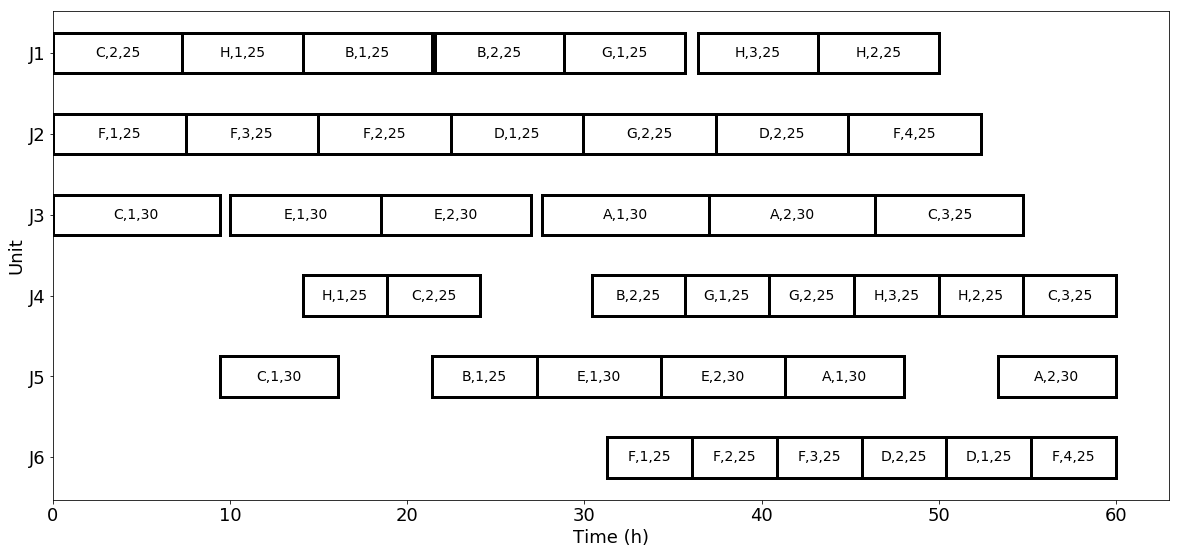

In [36]:
model_pp(model)
plot_gantt(model)

## Again, we have multiple solutions (DUE TO NO CHANGEOVER COST), we will fix a few variables and show the problem still have the same objective value

In [37]:
fixingset = {}
fixingset['J1'] = [('H',3,5),('C',2,10),('B',1,20),('H',1,25),('B',2,35),('H',2,40),('G',2,50)]
fixingset['J2'] = [('F',2,5),('D',2,10),('D',1,20),('G',1,25),('F',4,35),('F',1,45),('F',3,50)]
fixingset['J3'] = [('C',1,5),('E',2,15),('A',1,25),('A',2,35),('E',1,45),('C',1,50)]

fixingset['J4'] = [('H',3,10),('D',2,15),('B',1,25),('G',1,30),('C',2,35),('B',2,40),('H',2,45),('H',1,50),('C',3,55)]
fixingset['J5'] = [('C',1,15),('E',2,25),('A',1,30),('A',2,40),('E',1,50),('G',2,55)]
fixingset['J6'] = [('F',2,10),('D',1,25),('F',4,45),('F',1,50),('F',3,55)]

for j in fixingset.keys():
    for i, l,t in fixingset[j]:
        model.X[i,l,j].fix(1)

In [38]:
model.T['A',1,'K1'].setub(30);model.T['A',1,'K1'].setlb(25);
model.T['A',2,'K1'].setub(40);model.T['A',2,'K1'].setlb(35);

model.T['B',1,'K1'].setub(25);model.T['B',1,'K1'].setlb(20);
model.T['B',2,'K1'].setub(40);model.T['B',2,'K1'].setlb(35);

model.T['C',1,'K1'].setub(12);model.T['C',1,'K1'].setlb(5);
model.T['C',2,'K1'].setub(15);model.T['C',2,'K1'].setlb(10);
model.T['C',3,'K1'].setub(60);model.T['C',3,'K1'].setlb(50);

model.T['D',1,'K1'].setub(25);model.T['D',1,'K1'].setlb(20);
model.T['D',2,'K1'].setub(20);model.T['D',2,'K1'].setlb(10);

model.T['E',1,'K1'].setub(50);model.T['E',1,'K1'].setlb(45);
model.T['E',2,'K1'].setub(20);model.T['E',2,'K1'].setlb(15);

model.T['H',1,'K1'].setub(30);model.T['H',1,'K1'].setlb(25);
model.T['H',2,'K1'].setub(45);model.T['H',2,'K1'].setlb(40);
model.T['H',3,'K1'].setub(10);model.T['H',3,'K1'].setlb(5);

In [39]:
model.T['A',1,'K2'].setub(40);model.T['A',1,'K2'].setlb(30);
model.T['A',2,'K2'].setub(45);model.T['A',2,'K2'].setlb(40);

model.T['B',1,'K2'].setub(30);model.T['B',1,'K2'].setlb(25);
model.T['B',2,'K2'].setub(50);model.T['B',2,'K2'].setlb(40);

model.T['C',1,'K2'].setub(20);model.T['C',1,'K2'].setlb(15);
model.T['C',2,'K2'].setub(45);model.T['C',2,'K2'].setlb(35);
model.T['C',3,'K2'].setub(60);model.T['C',3,'K2'].setlb(50);

model.T['D',1,'K2'].setub(30);model.T['D',1,'K2'].setlb(25);
model.T['D',2,'K2'].setub(20);model.T['D',2,'K2'].setlb(15);

model.T['E',1,'K2'].setub(55);model.T['E',1,'K2'].setlb(50);
model.T['E',2,'K2'].setub(30);model.T['E',2,'K2'].setlb(20);

model.T['H',1,'K2'].setub(60);model.T['H',1,'K2'].setlb(50);
model.T['H',2,'K2'].setub(55);model.T['H',2,'K2'].setlb(45);
model.T['H',3,'K2'].setub(15);model.T['H',3,'K2'].setlb(5);

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Parameter mipgap unchanged
   Value: 0.0  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 16450 rows, 6550 columns and 89968 nonzeros
Variable types: 487 continuous, 6063 integer (6063 binary)
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [6e+00, 3e+03]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+02]
Presolve removed 8962 rows and 2357 columns
Presolve time: 0.30s
Presolved: 7488 rows, 4193 columns, 40726 nonzeros
Variable types: 258 continuous, 3935 integer (3935 binary)

Root relaxation: objective 2.102667e+03, 233 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2102.66667    0   11          - 2102.66667      -     -    0s
H    0     0     

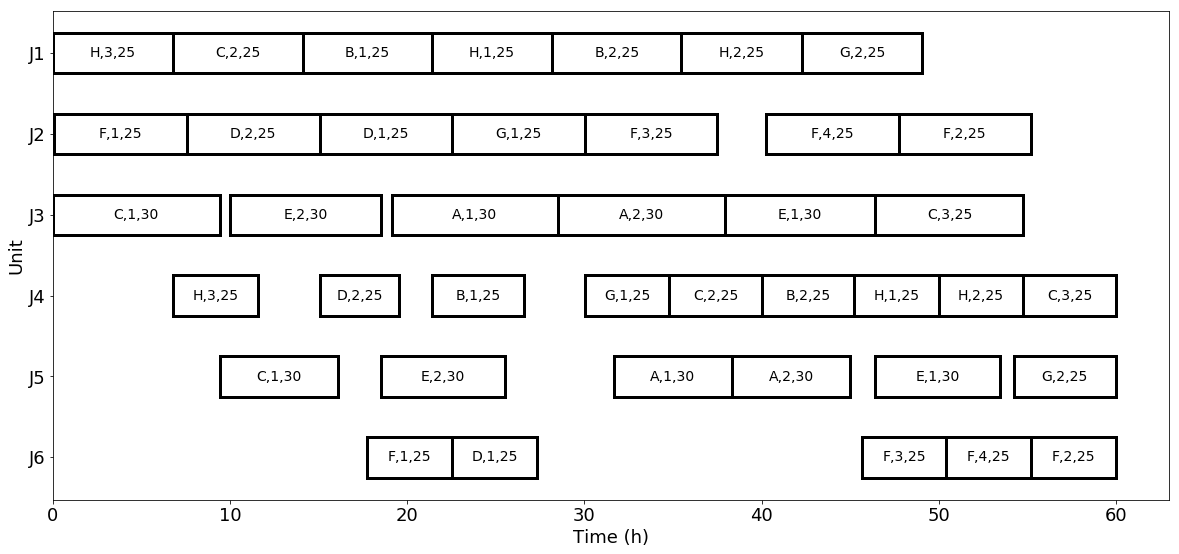

In [40]:
opt.solve(model,options={'mipgap':0},tee=True);
model_pp(model)
plot_gantt(model)